In [ ]:
### To-Do
# 1) plot some variables before and after normalization. how do they compare?
# X) try batch normalization in the network? re-do step1 maybe?
# 3) to_categorical for signal and background preds?
# 4) grid optimization? --> dropout rate, layers, nodes, etc
# X) k-fold validation

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from lbn import LBN, LBNLayer

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

In [3]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

(array([3.3195e+04, 4.0870e+04, 2.5949e+04, 1.1225e+04, 3.8130e+03,
        1.1030e+03, 2.6100e+02, 5.6000e+01, 5.0000e+00, 4.0000e+00]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <a list of 10 Patch objects>)

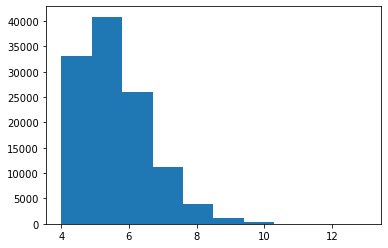

In [95]:
plt.hist(qcd_raw.nJets, bins=10)

In [4]:
# *** 2. Make mix of dihiggs and QCD for specified variables
jetLabels = ['1','2','3','4','5','6','7','8']
jetVariables = ['energy', 'px', 'py', 'pz']
variables_jetVects = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]

# *** 2. Split testing and training
jetVects_data_train, jetVects_data_test, jetVects_labels_train, jetVects_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_jetVects, testingFraction)

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [5]:
# *** 2. Create jet vector inputs
def returnJetVectorInputsToLBN(_df, _jetType='jet', _nJets=4):
    
    #flattened
    _allVectorsFlattened = None
    _var = [_jetType+'{}_energy', _jetType+'{}_px', _jetType+'{}_py', _jetType+'{}_pz']
    
    for i in range(1, _nJets + 1):
        _varN = [x.format(i) for x in _var]
        _jetNData = _df[ _varN ].astype(np.float32)
        _vectN = [list(x) for x in _jetNData.values]
        
        if _allVectorsFlattened == None:
            _allVectorsFlattened = _vectN
        else:
            _allVectorsFlattened = [ x + y for x,y in zip(_allVectorsFlattened, _vectN) ]

    return np.array(_allVectorsFlattened)
    

nJets = 8
jetType = 'jet'
trainVectorsByEvent = returnJetVectorInputsToLBN( jetVects_data_train, jetType, nJets)
testVectorsByEvent  = returnJetVectorInputsToLBN( jetVects_data_test, jetType, nJets)

trainLabelsByEvent = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_train.isSignal]).astype(np.float32)
testLabelsByEvent  = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_test.isSignal]).astype(np.float32)

#np.array(jetVects_labels_train)
np.shape(trainVectorsByEvent)
#np.array(trainLabelsByEvent)

(136749, 32)

In [102]:
# *** 3A. Define LBN model and train
#init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=123)
model = tf.keras.models.Sequential()

features = ["E", "pt", "eta", "phi", "m", "pair_dr"]
model.add(LBNLayer(13, boost_mode=LBN.PAIRS, features=features))


#model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=init))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(BatchNormalization())

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=25, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400)
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model.count_params())

Train on 136749 samples, validate on 58608 samples
Epoch 1/25
136749/136749 [==============================] - 13s 94us/sample - loss: 0.6570 - accuracy: 0.6824 - val_loss: 0.5454 - val_accuracy: 0.7121
Epoch 2/25
136749/136749 [==============================] - 10s 71us/sample - loss: 0.5445 - accuracy: 0.7146 - val_loss: 0.5404 - val_accuracy: 0.7157
Epoch 3/25
136749/136749 [==============================] - 11s 82us/sample - loss: 0.5338 - accuracy: 0.7246 - val_loss: 0.5381 - val_accuracy: 0.7239
Epoch 4/25
136749/136749 [==============================] - 9s 67us/sample - loss: 0.5155 - accuracy: 0.7400 - val_loss: 0.5146 - val_accuracy: 0.7401
Epoch 5/25
136749/136749 [==============================] - 12s 85us/sample - loss: 0.5013 - accuracy: 0.7510 - val_loss: 0.4917 - val_accuracy: 0.7589
Epoch 6/25
136749/136749 [==============================] - 10s 76us/sample - loss: 0.4855 - accuracy: 0.7632 - val_loss: 0.4862 - val_accuracy: 0.7616
Epoch 7/25
136749/136749 [============

In [ ]:
# *** 3B. Define low-level NN using jet vectors for comparison
model_nn = tf.keras.models.Sequential()
nInputNodes = len(trainVectorsByEvent[0]) 
#model.add(Dense(100, input_dim=nInputNodes, activation='relu'))

model_nn.add(tf.keras.layers.Dense(128, input_dim = nInputNodes, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(BatchNormalization())

model_nn.add(tf.keras.layers.Dense(64, activation='relu'))
model_nn.add(tf.keras.layers.Dense(32, activation='relu'))
model_nn.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_nn = model_nn.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=25, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400)
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model_nn.count_params())

In [116]:
# *** 4. Do some very specific evaluation based on pure samples
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(testVectorsByEvent, testLabelsByEvent)

#score_hh = model.evaluate(np.array(hh_data_test), np.array(hh_labels_test))
#score_qcd = model.evaluate(np.array(qcd_data_test), np.array(qcd_labels_test))
#print(score_hh, score_qcd)

pred_hh = model.predict(np.array(hh_data_test))
pred_qcd = model.predict(np.array(qcd_data_test))

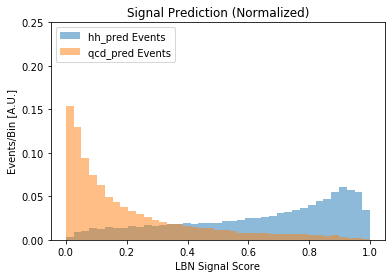

In [117]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh[:,0], 'qcd_pred':pred_qcd[:,0]}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'LBN Signal Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [110]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh[:,0].copy(), pred_qcd[:,0].copy(), _minBackground=200, _testingFraction=testingFraction)

23724 34884
nSig = 4355.169599999999 , nBkg = 28851640.47 with significance = 0.8108113439837802 for ff-NN score > 0.4141416591827316


(0.8108113439837802, 0.4141416591827316)

In [ ]:
# *** 5. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

In [ ]:
import pickle
pickle.dump(model, open('models/allVars_100-50-50.pkl', 'wb'))


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


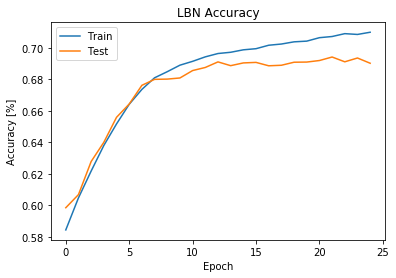

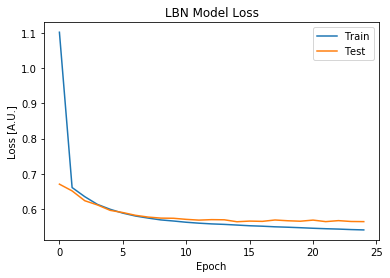

In [118]:
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LBN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LBN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [91]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lbn_layer_9 (LBNLayer)       multiple                  208       
_________________________________________________________________
dense_35 (Dense)             multiple                  8448      
_________________________________________________________________
dense_36 (Dense)             multiple                  8256      
_________________________________________________________________
dense_37 (Dense)             multiple                  2080      
_________________________________________________________________
dense_38 (Dense)             multiple                  66        
Total params: 19,058
Trainable params: 19,058
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ROC curve and AUC
testVectorsByEvent_ROC = testVectorsByEvent.copy()
#top10_data_test_ROC = top10_data_test__norm.copy()
#top10_data_test_ROC = top10_data_test_ROC.drop('isSignal', axis=1)

y_pred = model.predict(testVectorsByEvent_ROC).ravel()
falsePositiveRate, truePositiveRate, thresholds = roc_curve(testLabelsByEvent, y_pred)
auc_keras = auc(falsePositiveRate, truePositiveRate)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(falsePositiveRate, truePositiveRate, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
var = ['jet{}_E', 'jet{}_px', 'jet{}_py', 'jet{}_pz', 'jet{}_m']
for i in range(1,5):
    varN = [x.format(i) for x in var]
    print(varN)

In [ ]:
je